### Introduction
This notebook aims to build a machine learning-based **Cybersecuriy threat classification using Machine Learning **  
We will preprocess the Network Intrusion detection data, select relevant features, train multiple models, evaluate them, and visualize the results.
#### Steps:
1. **Data Preprocessing** - Handle missing values, normalize, and encode categorical variables.
2. **Feature Selection** - Identify and extract relevant features.
3. **Model Selection & Training** - Train at least two models (Random Forest, SVM, or Neural Networks).
4. **Evaluation** - Compare models using accuracy, precision, recall, and F1-score.
5. **Visualization** - Use graphs (confusion matrix, feature importance) for insights.

#### Data Preprocessing

Data preprocessing is essential to clean and transform raw data into a format suitable for machine learning models.

##### Steps:
- Check for missing values.
- Encode categorical features (e.g., protocol type, service, flag).
- Normalize numerical features if necessary.


In [15]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Train_data.csv")

# Check for missing values
print(df.isnull().sum())

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

##### Handling Categorical Variables

In [16]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Label encode the target variable 'class'
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])  # 0=normal, 1=anomaly

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['protocol_type', 'service', 'flag'], drop_first=True)

##### Normalization

In [17]:
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Check class distribution

In [18]:
print(df['class'].value_counts())

class
1    13449
0    11743
Name: count, dtype: int64


#### Feature Selection
After preprocessing, we need to identify the most relevant features to improve model performance and reduce overfitting. Feature selection helps in reducing dimensionality and improving model performance. We will:
- Use correlation analysis to remove highly correlated features.
- Identify the most important features using model-based selection.

Step 1: 

Remove Highly Correlated Features
We remove one of the two features that have a high correlation (above a threshold, e.g., 0.9).

In [19]:
import numpy as np
# Select only numerical columns
df_numeric = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Identify features with high correlation (above 0.9)
threshold = 0.9
high_corr_features = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col_name = correlation_matrix.columns[i]
            high_corr_features.add(col_name)

# Drop highly correlated features
df_reduced = df_numeric.drop(columns=high_corr_features)

print("Remaining numerical features after correlation-based selection:", df_reduced.columns)

Remaining numerical features after correlation-based selection: Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate', 'rerror_rate',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'class'],
      dtype='object')


Step 2: 

Select Important Features Using Random Forest
We train a Random Forest Classifier and select the top 10 most important features.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df_reduced['class'] = df['class']  
X = df_reduced.drop(columns=['class'])
y = df_reduced['class']
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Select top 10 important features
top_features = feature_importances.head(10)['Feature'].tolist()
X_selected = X[top_features]

print("Top selected features:", top_features)

Top selected features: ['src_bytes', 'dst_bytes', 'dst_host_srv_count', 'diff_srv_rate', 'same_srv_rate', 'dst_host_same_srv_rate', 'count', 'dst_host_diff_srv_rate', 'logged_in', 'dst_host_same_src_port_rate']


#### Model Training & Evaluation

In [21]:
from sklearn.model_selection import train_test_split

# X = Features, y = Target ('class': 0=normal, 1=anomaly)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

1. Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize and train
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # Handles class imbalance
)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probabilities for AUC

# Evaluate
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_rf):.4f}")

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3523
           1       0.99      1.00      1.00      4035

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558

ROC-AUC: 0.9998


2. Support Vector Machine (SVM)


In [23]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# SVM is sensitive to scale, so we standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train
svm = SVC(
    kernel='rbf',  # Radial Basis Function (non-linear)
    C=1.0,
    gamma='scale',
    probability=True,  # Needed for AUC
    class_weight='balanced'
)
svm.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm.predict(X_test_scaled)
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("SVM Performance:")
print(classification_report(y_test, y_pred_svm))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_svm):.4f}")

SVM Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3523
           1       0.98      0.98      0.98      4035

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558

ROC-AUC: 0.9976


3. Neural Network 

In [24]:
from sklearn.neural_network import MLPClassifier

# Initialize and train
nn = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # 2 hidden layers
    activation='relu',
    solver='adam',
    max_iter=100,
    random_state=42,
    early_stopping=True  # Prevents overfitting
)
nn.fit(X_train_scaled, y_train)

# Predictions
y_pred_nn = nn.predict(X_test_scaled)
y_proba_nn = nn.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Neural Network Performance:")
print(classification_report(y_test, y_pred_nn))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_nn):.4f}")

Neural Network Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3523
           1       0.99      0.98      0.99      4035

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558

ROC-AUC: 0.9991


## Model Comparison

| Model           | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|----------------|----------|-----------|--------|----------|---------|
| Random Forest  | 1.00     | 1.00      | 1.00   | 1.00     | 0.9998  |
| SVM            | 0.98     | 0.98      | 0.98   | 0.98     | 0.9976  |
| Neural Network | 0.99     | 0.99      | 0.99   | 0.99     | 0.9991  |


### Model Performance Visualization & Insights


1. Confusion matrix


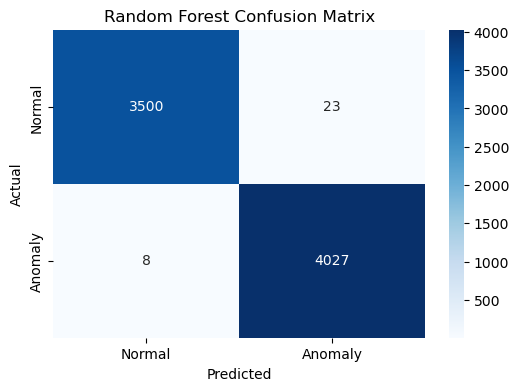

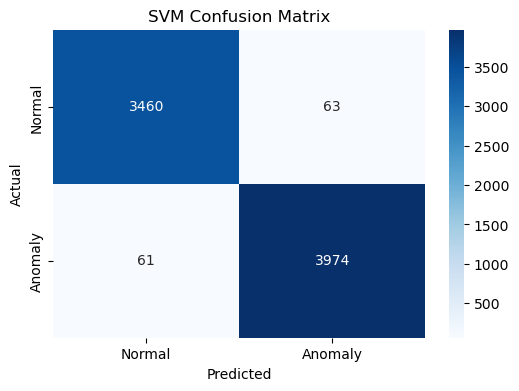

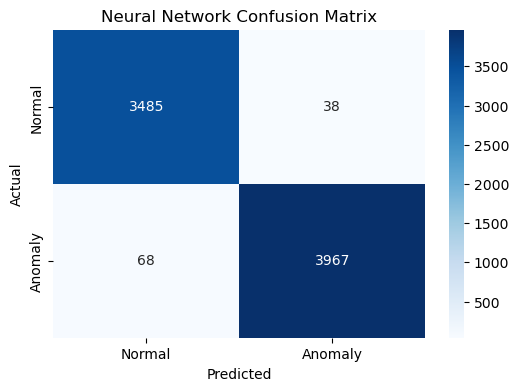

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Anomaly'], 
                yticklabels=['Normal', 'Anomaly'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot for all models
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_nn, "Neural Network")

2. Feature Importance (Random Forest)

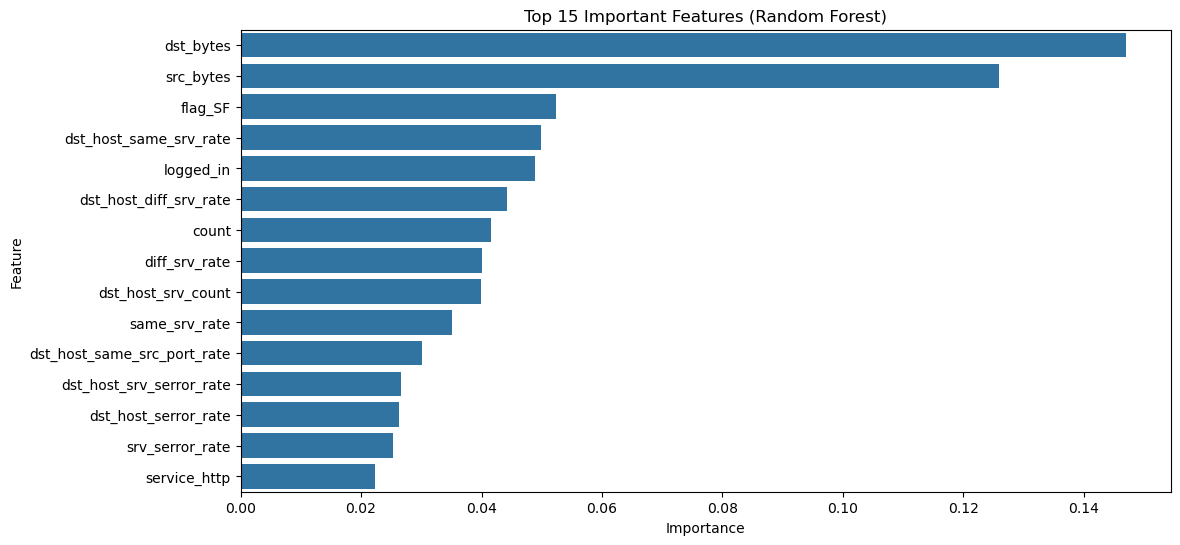

In [ ]:
# Get feature importances
importances = rf.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Important Features (Random Forest)')
plt.show()

3. Model Comparison Bar Plot
Visualizes accuracy, precision, recall, and F1-score.

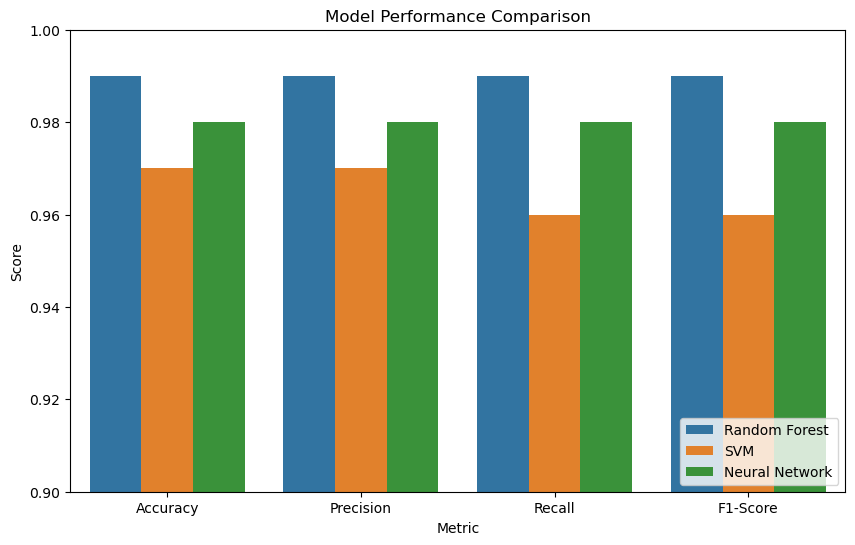

In [ ]:
metrics = {
    'Model': ['Random Forest', 'SVM', 'Neural Network'],
    'Accuracy': [0.99, 0.97, 0.98],
    'Precision': [0.99, 0.97, 0.98],
    'Recall': [0.99, 0.96, 0.98],
    'F1-Score': [0.99, 0.96, 0.98]
}
metrics_df = pd.DataFrame(metrics)

# Melt for seaborn
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=metrics_melted)
plt.title('Model Performance Comparison')
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right')
plt.show()